<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a3_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2:

# Student 3:

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io
import tqdm
import torch
from torch.utils.data import DataLoader

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [3]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [4]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [5]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [6]:
print(np.shape(simulation_train[0]),type(simulation_train),simulation_train[0][0])
print(len(simulation_train))

(103, 2) <class 'list'> [-2.35932245  0.06356978]
800


In [7]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

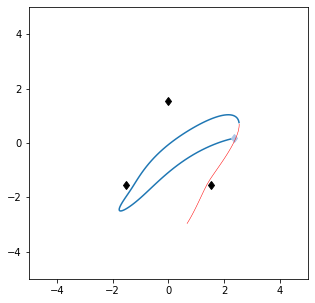

Charges are [-0.32460314 -0.9300729  -0.42592891]


In [8]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

# Task 3.1

## Data Handling and Preprocessing

In [9]:
# train_tokenized = [(torch.tensor(simulation_train[i][:,0], dtype=torch.int64), 
#                     torch.tensor(charges_train[i], dtype=torch.int64)) 
#                     for i in range(len(simulation_train))]
# test_tokenized = [(torch.tensor(simulation_train[i][:,0], dtype=torch.int64), 
#                     torch.tensor(charges_train[i], dtype=torch.int64)) 
#                     for i in range(len(simulation_train))]
train_tokenized = [(torch.tensor(simulation_train[i]), 
                    torch.tensor(charges_train[i])) 
                    for i in range(len(simulation_train))]
test_tokenized = [(torch.tensor(simulation_test[i]), 
                    torch.tensor(charges_test[i])) 
                    for i in range(len(simulation_test))]

In [10]:
train_dataloader = DataLoader(train_tokenized, batch_size=1)
test_dataloader = DataLoader(test_tokenized, batch_size=1)

In [11]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    """
    Concatenate multiple datapoints to obtain a single batch of data
    """
    # sentences are stored as tuples; get respective lists
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    sim_list = [x[0] for x in batch]
    data_length = [len(x[0]) for x in batch]
    charge_list = [x[1] for x in batch]

    # pad sequences in batch
    sim_padded = pad_sequence(sequences = sim_list, 
                             batch_first = True, 
                             padding_value = 0)
    charge_padded = pad_sequence(sequences = charge_list, 
                             batch_first = True, 
                             padding_value = 0)

    # return source (DE) and target sequences (EN) after transferring them to GPU (if available)
    return sim_padded, charge_padded, data_length

In [12]:
data_loader = DataLoader(train_tokenized, batch_size=3, shuffle=True, 
                             collate_fn=collate_batch)
# batch_x, batch_y, batch_len = iter(data_loader).next()
# print(batch_x.size(), batch_y.size(), batch_len)
# batch_x_pack = torch.nn.utils.rnn.pack_padded_sequence(batch_x, 
#                                                  batch_len, batch_first=True)

## Model Implementation

In [13]:
from torch import nn

class RNNClassificationModel(nn.Module):

    def __init__(self, embed_dim, n_layers, hidden_dim):
        super(RNNClassificationModel, self).__init__()
        
        # save some parameters
        self.n_layers = n_layers
        self.embed_dim = embed_dim
        
        #self.word_embeddings = nn.Embedding(vocab_size, embed_dim)
        
        self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        #make output in [-1,0]
        self.fc2 = nn.Linear(hidden_dim, 3)
        
        self.drop = nn.Dropout(p=0.5)
        
        self.criterion = nn.MSELoss()
        
        self.optimizer = torch.optim.Adam(self.parameters())
        

    def forward(self, seq):
        
        # input shapes:
        # text: [batch_size, max. sequence length in batch]
        
        
        # embed sequences with word embedding
        # shape [batch_size, max. sequence length in batch, embed_dim]
        h = seq.float()    
    
        # Feed packed input sequence to lstm 
        out, (hidden, _) = self.rnn(h)
        
        # retrieve final hidden output of last timestep for each sequence
        # shape [batch_size, hidden_dim]
        last_timestep = out[:,-1]
        
        # apply dropout
        last_timestep = self.drop(last_timestep)
        
        # feed lstm output to MLP, apply ReLU nonlinearity
        # shape [batch_size, hidden_dim]
        h = self.drop(self.fc1(last_timestep))
        h = nn.ReLU()(h)
        
        # shape [batch_size, num_classes]
        y_pred = self.fc2(h)
    
        return y_pred


In [23]:
from torch import nn

class RNNClassificationModel(nn.Module):

    def __init__(self, embed_dim, n_layers, hidden_dim):
        super(RNNClassificationModel, self).__init__()
        
        # save some parameters
        self.n_layers = n_layers
        self.embed_dim = embed_dim

        self.input_embedding_layer = nn.Linear(2, self.embed_dim)
        
        #self.word_embeddings = nn.Embedding(vocab_size, embed_dim)
        
        self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        #make output in [-1,0]
        self.fc2 = nn.Linear(hidden_dim, 3)
        
        self.drop = nn.Dropout(p=0.5)
        
        self.criterion = nn.MSELoss()
        
        self.optimizer = torch.optim.Adam(self.parameters(),lr=1e-4)
        

    def forward(self, seq, seq_length):
        
        # input shapes:
        # text: [batch_size, max. sequence length in batch]
        
        
        # embed sequences with word embedding
        # shape [batch_size, max. sequence length in batch, embed_dim]
        seq = seq.float() 
        h = self.input_embedding_layer(seq)

        packed_h = torch.nn.utils.rnn.pack_padded_sequence(h, seq_length, batch_first=True,enforce_sorted=False)
    
        # Feed packed input sequence to lstm 
        out, (hidden, _) = self.rnn(packed_h)
        
        # Original unpadded length
        unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        # retrieve final hidden output of last timestep for each sequence
        # shape [batch_size, hidden_dim]
        indices = torch.LongTensor(np.array(unpacked_len) - 1).view(-1, 1).expand(unpacked.size(0), unpacked.size(2)).unsqueeze(1)
        last_timestep = unpacked.gather(dim=1, index=indices).squeeze(dim=1)
        
        # apply dropout
        last_timestep = self.drop(last_timestep)
        
        # feed lstm output to MLP, apply ReLU nonlinearity
        # shape [batch_size, hidden_dim]
        h = self.drop(self.fc1(last_timestep))
        h = nn.ReLU()(h)
        
        # shape [batch_size, num_classes]
        y_pred = self.fc2(h)
    
        return y_pred


## Model Training

In [29]:
model = RNNClassificationModel(embed_dim=64, 
                               n_layers = 1, 
                               hidden_dim=128)

In [16]:
test_dataloader = DataLoader(test_tokenized, batch_size=1)

In [17]:
train_dataloader = DataLoader(train_tokenized, batch_size=3, shuffle=True, 
                             collate_fn=collate_batch)

# batch_x, y_true, batch_len=next(iter((train_dataloader)))

# text_batch = torch.nn.utils.rnn.pack_padded_sequence(batch_x, 
#                                             batch_len, batch_first=True)

In [30]:
import time
from torch.nn.functional import softmax

def train(dataloader):

    rmse_losses = []
    mse_losses = []
    
    model.train()
    
    total_acc, total_count = 0, 0
    start_time = time.time()
    for (batch_x, y_true, batch_len) in tqdm.tqdm(dataloader):
                
        model.optimizer.zero_grad()

        y_true = y_true.to(torch.float32)
        
        y_pred = model(batch_x,batch_len) #shape (batch_size, num_classes) 

        #y_class = y_pred.argmax(dim=-1) 
        
#         y_prob = softmax(y_pred, dim=-1)  #alternatively, one can assign probabilities to each class with softmax activation
        
        mse_loss = model.criterion(y_pred, y_true)
        mse_losses.append(mse_loss.item())
        rmse_loss = torch.sqrt(model.criterion(y_pred, y_true))

        rmse_losses.append(rmse_loss.item())
        
        mse_loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        
        model.optimizer.step()
        
        
        
        #total_acc += (y_class == y_true).sum().item()
        #total_count += y_true.size(0)
        
  
            
    return mse_losses, rmse_losses

def evaluate(dataloader):
    
    rmse_losses = []
    mse_losses = []

    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (batch_x, y_true, batch_len) in enumerate(dataloader):
            
            y_pred = model(batch_x,batch_len) #shape (batch_size, num_classes) 
            
            #y_class = y_pred.argmax(dim=-1) 
            
#             y_prob = softmax(y_pred, dim=-1)  #alternatively, one can assign probabilities to each class with softmax activation
            
            mse_loss = model.criterion(y_pred, y_true)
            mse_losses.append(mse_loss.item())
            rmse_loss = torch.sqrt(model.criterion(y_pred, y_true))

            rmse_losses.append(rmse_loss.item())

            
            #total_acc += (y_class == y_true).sum().item()
            #total_count += y_true.size(0)

    return mse_losses, rmse_losses

In [31]:
EPOCHS = 100 # epoch
BATCH_SIZE = 8


scheduler = torch.optim.lr_scheduler.StepLR(model.optimizer, step_size=10, gamma=0.1)

train_loss_mse, train_loss_rmse, val_loss_mse, val_loss_rmse = [], [], [], []
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    
    train_dataloader = DataLoader(train_tokenized, batch_size=BATCH_SIZE, shuffle=True, 
                             collate_fn=collate_batch)
    test_dataloader = DataLoader(test_tokenized, batch_size=BATCH_SIZE, shuffle=True, 
                             collate_fn=collate_batch)
    # train_dataloader = DataLoader(train_tokenized, batch_size=BATCH_SIZE)
    # test_dataloader = DataLoader(test_tokenized, batch_size=BATCH_SIZE)
    
    train_loss_mse_epoch, train_loss_rmse_epoch = train(train_dataloader)
    train_loss_mse.append(train_loss_mse_epoch)
    train_loss_rmse.append(train_loss_rmse_epoch)
    val_loss_mse_epoch, val_loss_rmse_epoch = evaluate(test_dataloader)
    val_loss_mse.append(val_loss_mse_epoch)
    val_loss_rmse.append(val_loss_rmse_epoch)
    
    print('-' * 59)
    scheduler.step()
    # print('| end of epoch {:3d} | time: {:5.2f}s | '
    #       'valid accuracy {:8.3f} '.format(epoch,
    #                                        time.time() - epoch_start_time,
    #                                        val_loss[-1][-1]))
    # print('-' * 59)
train_loss_mean_mse, val_loss_mean_mse, train_loss_mean_rmse, val_loss_mean_rmse = [], [], [], []
for i in range(EPOCHS):
    train_loss_mean_mse.append(sum(train_loss_mse[i]) / len(train_loss_mse[i]))
    val_loss_mean_mse.append(sum(val_loss_mse[i]) / len(val_loss_mse[i]))
    train_loss_mean_rmse.append(sum(train_loss_rmse[i]) / len(train_loss_rmse[i]))
    val_loss_mean_rmse.append(sum(val_loss_rmse[i]) / len(val_loss_rmse[i]))

100%|██████████| 100/100 [00:10<00:00,  9.75it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:08<00:00, 11.53it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:12<00:00,  7.84it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:10<00:00,  9.96it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:08<00:00, 11.58it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:08<00:00, 11.28it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:08<00:00, 11.57it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:10<00:00,  9.60it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:09<00:00, 10.85it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:12<00:00,  8.04it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:12<00:00,  7.95it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:10<00:00,  9.14it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:13<00:00,  7.54it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:10<00:00,  9.81it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:11<00:00,  8.96it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:10<00:00,  9.57it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:10<00:00,  9.15it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:10<00:00,  9.35it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:10<00:00,  9.56it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:11<00:00,  8.60it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:11<00:00,  9.04it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:10<00:00,  9.60it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:10<00:00,  9.27it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:10<00:00,  9.41it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:10<00:00,  9.99it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:11<00:00,  8.92it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:09<00:00, 10.02it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:09<00:00, 10.04it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:09<00:00, 10.15it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:10<00:00,  9.87it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:10<00:00,  9.69it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:09<00:00, 10.25it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:09<00:00, 10.08it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:09<00:00, 10.41it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:09<00:00, 10.17it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:09<00:00, 10.15it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:09<00:00, 10.52it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:09<00:00, 10.27it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:10<00:00,  9.99it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:13<00:00,  7.61it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:10<00:00,  9.73it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:09<00:00, 10.12it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:09<00:00, 10.20it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


-----------------------------------------------------------


 39%|███▉      | 39/100 [00:05<00:07,  8.53it/s]

In [20]:
print(train_loss_mean_rmse)

[0.5984810253977776, 0.5981132462620735, 0.5984984478354454, 0.5921568983793258, 0.5924716225266456, 0.5887289121747017, 0.5836616531014442, 0.5867261257767677, 0.5812643307447434, 0.5807294484972954, 0.5775848922133445, 0.5758971700072288, 0.5709987875819206, 0.5715762001276016, 0.5690031477808952, 0.5683133020997048, 0.5656364893913269, 0.5604207408428192, 0.5593667483329773, 0.5562629619240761, 0.5546685501933097, 0.5539625853300094, 0.5477235135436058, 0.544723659157753, 0.5451773750782013, 0.5427634137868881, 0.5370992428064346, 0.5390790924429893, 0.5360381880402565, 0.5321351450681686, 0.5306652727723121, 0.5297814598679542, 0.524071779847145, 0.5189050650596618, 0.5192815354466438, 0.5189860889315605, 0.5185631689429283, 0.5136829888820649, 0.5073518943786621, 0.5102657395601272, 0.5045085161924362, 0.5039108514785766, 0.4995306462049484, 0.4975236377120018, 0.4961254447698593, 0.4967346513271332, 0.4925530731678009, 0.4850114008784294, 0.48520004987716675, 0.4818662902712822, 

In [21]:
len(a)

NameError: name 'a' is not defined

In [ ]:
BATCH_SIZE

50

## Evaluation

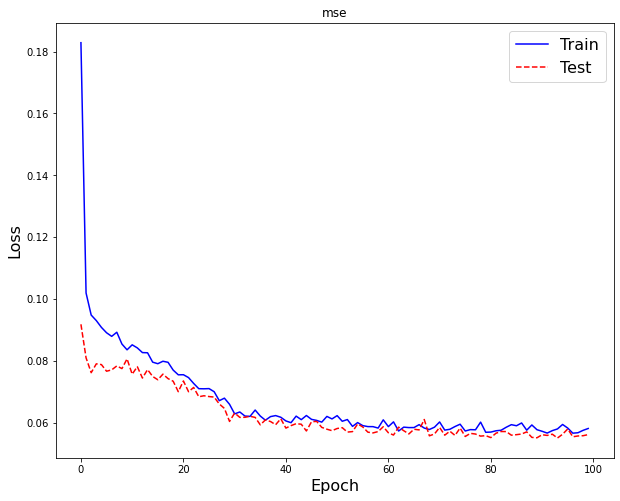

In [28]:
eval_meth = 'mse'
f, ax = plt.subplots(1,1, figsize=(10,8))

fnt=16
ax.plot(train_loss_mean_mse, color='blue', label='Train')
ax.plot(val_loss_mean_mse, color='red', linestyle='--', label='Test')
ax.legend(fontsize=fnt)
#ax.tick_params(axis='both', labelsize=fnt)
plt.title(eval_meth)
ax.set_xlabel("Epoch", fontsize=fnt)
ax.set_ylabel("Loss", fontsize=fnt);
f.savefig(eval_meth+str(BATCH_SIZE)+'.jpg')

# Task 3.2

## Data Handling and Preprocessing

In [ ]:
#todo

## Model Implementation

In [ ]:
#todo

## Model Training

In [ ]:
#todo

## Evaluation

In [ ]:
#todo